# Fine-tune MedSigLIP for Surgical Wound Assessment

**MamaGuard — Wound Assessment Component**

Fine-tunes `google/medsiglip-448` vision encoder on the [SurgWound dataset](https://huggingface.co/datasets/xuxuxuxuxu/SurgWound)
for **6 binary clinical labels**: healing status, erythema, edema, infection risk, urgency, and exudate.

The fine-tuned model serves as a structured clinical signal provider in a two-stage pipeline:
```
Wound photo → MedSigLIP (this model) → structured scores → Gemini/MedGemma orchestrator → empathetic response
```

### Key Design Decisions
- **Selective freezing**: Only last 4 encoder blocks + classification head are trainable (~13-15% of params) to fit T4 16GB
- **Masked BCE loss**: 3 of 6 labels have MISSING values — loss is zeroed out for those entries instead of dropping entire samples
- **Light augmentation**: Horizontal flip + rotation + color jitter to compensate for small dataset (480 train images)
- **eval_loss for model selection**: Val set has only 69 images — per-label AUC too noisy for checkpoint comparison

### Dataset
- **Source**: SurgWound (686 images: 480 train / 69 val / 137 test)
- **Upload as Kaggle dataset** at `surgwound-dataset` for instant `/kaggle/input/` access

### References
- [MedSigLIP model](https://huggingface.co/google/medsiglip-448)
- [Google's fine-tuning notebook](https://github.com/google-health/medsiglip/blob/main/notebooks/fine_tune_for_image_classification.ipynb)
- [SurgWound dataset](https://huggingface.co/datasets/xuxuxuxuxu/SurgWound)

## 1. Setup

### GPU Requirements
This notebook is designed for **T4 (16GB)** on Kaggle free tier.
It will also work on P100 (16GB), L4 (24GB), or A100 (40GB+).

### Dataset Setup
Before running, upload the `data/surgwound/` folder (containing `labels.csv` + `images/` with 686 JPGs)
as a Kaggle dataset named `surgwound-dataset`. It will be accessible at `/kaggle/input/surgwound-dataset/`.

In [1]:
# ╔═══════════════════════════════════════════════════════════════════════════════╗
# ║ Install training dependencies (Kaggle already has torch + torchvision)      ║
# ║ No kernel restart needed — just run all cells top-to-bottom.                ║
# ╚═══════════════════════════════════════════════════════════════════════════════╝

import subprocess, sys

def _pip(*args):
    subprocess.check_call([sys.executable, "-m", "pip", "-q"] + list(args))

_pip(
    "install",
    "transformers>=4.46.0",
    "accelerate>=1.0.0",
    "datasets>=3.0.0",
    "evaluate>=0.4.0",
    "scikit-learn>=1.3.0",
    "tensorboard",
    "tqdm",
)

# ── Prevent transformers from importing Kaggle's broken torchvision ──────────
# Kaggle's pre-installed torchvision triggers PIL._typing._Ink ImportError.
# We don't need torchvision at all (pure PIL transforms), so disable it globally.
import transformers.utils.import_utils as _tiu
_tiu._torchvision_available = False

print("✓ Dependencies installed")
print("✓ torchvision disabled in transformers (pure PIL pipeline)")
print("\nRun all remaining cells — no kernel restart needed.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00
✓ Dependencies installed
✓ torchvision disabled in transformers (pure PIL pipeline)

Run all remaining cells — no kernel restart needed.


In [2]:
# ── Authenticate with Hugging Face ────────────────────────────────────────────
# Required to download gated model: google/medsiglip-448
#
# On Kaggle: Add your HF token as a Kaggle Secret named "HF_TOKEN"
# On Colab:  Add it to Colab Secrets, or it will prompt notebook_login()

import os
import sys

if "kaggle_secrets" in dir() or os.path.exists("/kaggle"):
    # Running on Kaggle
    try:
        from kaggle_secrets import UserSecretsClient
        secrets = UserSecretsClient()
        os.environ["HF_TOKEN"] = secrets.get_secret("HF_TOKEN")
        print("✓ HF_TOKEN loaded from Kaggle Secrets")
    except Exception as e:
        print(f"⚠ Could not load HF_TOKEN from Kaggle Secrets: {e}")
        print("  Falling back to huggingface_hub login...")
        from huggingface_hub import notebook_login
        notebook_login()
elif "google.colab" in sys.modules:
    # Running on Colab
    try:
        from google.colab import userdata
        os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
        print("✓ HF_TOKEN loaded from Colab Secrets")
    except Exception:
        from huggingface_hub import notebook_login
        notebook_login()
else:
    # Local / other environment
    from huggingface_hub import get_token
    if get_token() is None:
        from huggingface_hub import notebook_login
        notebook_login()
    else:
        print("✓ HF token already configured")

✓ HF_TOKEN loaded from Kaggle Secrets


## 2. Configuration

All hyperparameters and label definitions in one place.

In [3]:
# ── Force single-GPU mode on multi-GPU Kaggle runtimes ──────────────────────
# Must run BEFORE importing torch.
import os

if os.environ.get("CUDA_VISIBLE_DEVICES") != "0":
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(f"CUDA_VISIBLE_DEVICES={os.environ.get('CUDA_VISIBLE_DEVICES')}")

import torch
import numpy as np

# ── Paths ─────────────────────────────────────────────────────────────────────
# Adjust BASE_PATH depending on your environment:
#   Kaggle:  /kaggle/input/surgwound-dataset
#   Local:   ./data/surgwound

if os.path.exists("/kaggle/input/datasets/kkfkmf/surgwound-dataset"):
    BASE_PATH = "/kaggle/input/datasets/kkfkmf/surgwound-dataset"
elif os.path.exists("/kaggle/input/surgwound"):
    BASE_PATH = "/kaggle/input/surgwound"
else:
    BASE_PATH = "./data/surgwound"  # Local development

LABELS_CSV = os.path.join(BASE_PATH, "labels.csv")
IMAGES_DIR = os.path.join(BASE_PATH, "images")

# If Kaggle dataset was uploaded with directory mode=zip, images may arrive as images.zip
IMAGES_ZIP = os.path.join(BASE_PATH, "images.zip")
if not os.path.isdir(IMAGES_DIR) and os.path.isfile(IMAGES_ZIP):
    import zipfile
    print(f"Extracting {IMAGES_ZIP} ...")
    with zipfile.ZipFile(IMAGES_ZIP, "r") as zf:
        zf.extractall(BASE_PATH)
    print(f"✓ Extracted images to {IMAGES_DIR}")

# ── Model ─────────────────────────────────────────────────────────────────────
MODEL_ID = "google/medsiglip-448"
OUTPUT_DIR = "medsiglip-448-surgwound-6label"

# ── Label definitions ─────────────────────────────────────────────────────────
# 6 binary labels predicted from wound images
LABEL_NAMES = [
    "healing_status",   # 0: Healed, 1: Not Healed
    "erythema",         # 0: Non-existent, 1: Existent       (has MISSING)
    "edema",            # 0: Non-existent, 1: Existent       (has MISSING)
    "infection_risk",   # 0: Low, 1: Medium+High
    "urgency",          # 0: Green (home care), 1: Yellow+Red (needs attention)
    "exudate",          # 0: Non-existent, 1: Any exudate    (has MISSING)
]
NUM_LABELS = len(LABEL_NAMES)

id2label = {i: name for i, name in enumerate(LABEL_NAMES)}
label2id = {name: i for i, name in enumerate(LABEL_NAMES)}

# Precomputed from training split (non-MISSING samples only):
#   healing:   neg=282, pos=198  → 282/198 = 1.42
#   erythema:  neg=334, pos=129  → 334/129 = 2.59
#   edema:     neg=328, pos=50   → 328/50  = 6.56
#   infection: neg=402, pos=78   → 402/78  = 5.15
#   urgency:   neg=423, pos=57   → 423/57  = 7.42
#   exudate:   neg=367, pos=70   → 367/70  = 5.24
POS_WEIGHT = torch.tensor([1.42, 2.59, 6.56, 5.15, 7.42, 5.24])

# ── Freezing strategy ────────────────────────────────────────────────────────
N_UNFREEZE = 4  # Unfreeze last N encoder blocks + classification head

# ── Training hyperparameters ─────────────────────────────────────────────────
BATCH_SIZE = 4
GRAD_ACCUM = 16       # Effective batch = 4 × 16 = 64 (matches Google's 8×8)
EPOCHS = 5            # More passes for small dataset (480 images)
LR = 5e-5             # Matches Google's reference notebook
WARMUP_STEPS = 10
WEIGHT_DECAY = 0.01
SCHEDULER = "cosine"
FP16 = True           # T4 doesn't support bf16; fp16 saves VRAM

# ── Device ───────────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    visible_gpu_count = torch.cuda.device_count()
    print(f"Visible GPU count: {visible_gpu_count}")
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"✓ GPU: {gpu_name} ({gpu_mem:.1f} GB)")
    # Auto-adjust for larger GPUs
    if gpu_mem >= 30:  # A100 / L4
        BATCH_SIZE = 8
        GRAD_ACCUM = 8
        print(f"  → Adjusted: batch_size={BATCH_SIZE}, grad_accum={GRAD_ACCUM}")
else:
    print("⚠ No GPU detected — training will be extremely slow")
    FP16 = False

print(f"\nEffective batch size: {BATCH_SIZE * GRAD_ACCUM}")
forward_passes = (480 + BATCH_SIZE - 1) // BATCH_SIZE
optimizer_steps = (forward_passes + GRAD_ACCUM - 1) // GRAD_ACCUM
print(f"Forward passes per epoch: {forward_passes}")
print(f"Optimizer steps per epoch: {optimizer_steps}")
print(f"Dataset path: {BASE_PATH}")

CUDA_VISIBLE_DEVICES=0
Visible GPU count: 1
✓ GPU: Tesla T4 (15.6 GB)

Effective batch size: 64
Forward passes per epoch: 120
Optimizer steps per epoch: 8
Dataset path: /kaggle/input/datasets/kkfkmf/surgwound-dataset


## 3. Load & Validate Dataset

Read `labels.csv`, verify split counts (480/69/137), and print label distributions.
This cell fails fast if the dataset is corrupted or missing.

In [4]:
import pandas as pd
from pathlib import Path

# ── Load CSV ──────────────────────────────────────────────────────────────────
df = pd.read_csv(LABELS_CSV)
print(f"Loaded {len(df)} rows from {LABELS_CSV}")
print(f"Columns: {list(df.columns)}\n")

# ── Verify split counts ──────────────────────────────────────────────────────
split_counts = df["split"].value_counts().to_dict()
print("Split counts:", split_counts)

assert split_counts.get("train", 0) == 480, f"Expected 480 train, got {split_counts.get('train', 0)}"
assert split_counts.get("validation", 0) == 69, f"Expected 69 val, got {split_counts.get('validation', 0)}"
assert split_counts.get("test", 0) == 137, f"Expected 137 test, got {split_counts.get('test', 0)}"
print("✓ Split counts verified: 480 train / 69 val / 137 test\n")

# ── Verify all images exist on disk ──────────────────────────────────────────
missing_images = []
for _, row in df.iterrows():
    img_path = os.path.join(BASE_PATH, row["image_path"])
    if not os.path.exists(img_path):
        missing_images.append(img_path)

if missing_images:
    print(f"✗ {len(missing_images)} images missing! First 5:")
    for p in missing_images[:5]:
        print(f"  {p}")
    raise FileNotFoundError(f"{len(missing_images)} images not found on disk")
else:
    print(f"✓ All {len(df)} images verified on disk\n")

# ── Print label distributions for training split ─────────────────────────────
train_df = df[df["split"] == "train"]
print("=" * 60)
print("TRAINING SPLIT LABEL DISTRIBUTIONS")
print("=" * 60)
for col in ["healing_status", "erythema", "edema", "infection_risk", "urgency_level", "exudate_type"]:
    counts = train_df[col].value_counts()
    print(f"\n{col}:")
    for val, cnt in counts.items():
        pct = 100 * cnt / len(train_df)
        marker = " ← MISSING" if val == "MISSING" else ""
        print(f"  {val:55s} {cnt:4d} ({pct:5.1f}%){marker}")

print("\n" + "=" * 60)

Loaded 686 rows from /kaggle/input/datasets/kkfkmf/surgwound-dataset/labels.csv
Columns: ['img_id', 'image_path', 'split', 'wound_location', 'healing_status', 'closure_method', 'exudate_type', 'erythema', 'edema', 'urgency_level', 'infection_risk']

Split counts: {'train': 480, 'test': 137, 'validation': 69}
✓ Split counts verified: 480 train / 69 val / 137 test

✓ All 686 images verified on disk

TRAINING SPLIT LABEL DISTRIBUTIONS

healing_status:
  Healed                                                   282 ( 58.8%)
  Not Healed                                               198 ( 41.2%)

erythema:
  Non-existent                                             334 ( 69.6%)
  Existent                                                 129 ( 26.9%)
  MISSING                                                   17 (  3.5%) ← MISSING

edema:
  Non-existent                                             328 ( 68.3%)
  MISSING                                                  102 ( 21.2%) ← MISSING
  Ex

## 4. Label Encoding

Convert raw CSV labels into a 6-dimensional binary vector per image.

| # | Label | 0 (negative) | 1 (positive) | MISSING → -1 |
|---|---|---|---|---|
| 0 | healing_status | Healed | Not Healed | never |
| 1 | erythema | Non-existent | Existent | yes (17 in train) |
| 2 | edema | Non-existent | Existent | yes (102 in train) |
| 3 | infection_risk | Low | Medium or High | never |
| 4 | urgency | Home Care (Green) | Clinic Visit or Emergency | never |
| 5 | exudate | Non-existent | Any type present | yes (43 in train) |

In [5]:
def encode_labels(row: pd.Series) -> list[float]:
    """
    Convert a single CSV row into a 6-dim label vector.

    Returns:
        List of 6 floats: 0.0 (negative), 1.0 (positive), or -1.0 (MISSING).
        The masked loss function will ignore -1.0 entries.
    """
    labels = []

    # 0. healing_status: "Not Healed" → 1 (positive), "Healed" → 0
    labels.append(1.0 if row["healing_status"] == "Not Healed" else 0.0)

    # 1. erythema: "Existent" → 1, "Non-existent" → 0, "MISSING" → -1
    if row["erythema"] == "MISSING":
        labels.append(-1.0)
    else:
        labels.append(1.0 if row["erythema"] == "Existent" else 0.0)

    # 2. edema: "Existent" → 1, "Non-existent" → 0, "MISSING" → -1
    if row["edema"] == "MISSING":
        labels.append(-1.0)
    else:
        labels.append(1.0 if row["edema"] == "Existent" else 0.0)

    # 3. infection_risk: "Medium" or "High" → 1, "Low" → 0
    labels.append(1.0 if row["infection_risk"] in ("Medium", "High") else 0.0)

    # 4. urgency: anything other than "Home Care (Green)..." → 1
    labels.append(0.0 if row["urgency_level"].startswith("Home Care") else 1.0)

    # 5. exudate: "Non-existent" → 0, "MISSING" → -1, anything else → 1
    if row["exudate_type"] == "MISSING":
        labels.append(-1.0)
    elif row["exudate_type"] == "Non-existent":
        labels.append(0.0)
    else:
        labels.append(1.0)  # Serous, Sanguineous, Purulent, Seropurulent

    return labels


# ── Verify encoding on a few known examples ──────────────────────────────────
sample_row = train_df.iloc[0]
sample_labels = encode_labels(sample_row)
print(f"Sample row (img_id={sample_row['img_id']}):")
print(f"  healing_status = {str(sample_row['healing_status']):20s} → {sample_labels[0]}")
print(f"  erythema       = {str(sample_row['erythema']):20s} → {sample_labels[1]}")
print(f"  edema          = {str(sample_row['edema']):20s} → {sample_labels[2]}")
print(f"  infection_risk = {str(sample_row['infection_risk']):20s} → {sample_labels[3]}")
print(f"  urgency_level  = {str(sample_row['urgency_level'])[:30]:30s} → {sample_labels[4]}")
print(f"  exudate_type   = {str(sample_row['exudate_type']):20s} → {sample_labels[5]}")
print(f"\n  Encoded vector: {sample_labels}")

Sample row (img_id=0):
  healing_status = Not Healed           → 1.0
  erythema       = Non-existent         → 0.0
  edema          = Existent             → 1.0
  infection_risk = Medium               → 1.0
  urgency_level  = Home Care (Green): Manage with → 0.0
  exudate_type   = Non-existent         → 0.0

  Encoded vector: [1.0, 0.0, 1.0, 1.0, 0.0, 0.0]


## 5. Create HuggingFace Datasets

Build `Dataset` objects for train, validation, and test splits.
Each sample has an `image` (PIL) and `label` (6-dim float list).

In [6]:
from datasets import Dataset, Features, Value, Sequence, Image as HFImage
import PIL.Image  # Ensure PIL.Image is in sys.modules for datasets internals
from tqdm.auto import tqdm


def build_dataset_from_split(split_df: pd.DataFrame, split_name: str) -> Dataset:
    """
    Build a HuggingFace Dataset from a pandas DataFrame for one split.

    Loads images from disk and encodes labels as 6-dim float vectors.
    Uses explicit Features schema to avoid datasets library PIL type-inference bugs.
    """
    image_paths = []
    labels = []
    skipped = 0

    for _, row in tqdm(split_df.iterrows(), total=len(split_df), desc=f"Loading {split_name}"):
        img_path = os.path.join(BASE_PATH, row["image_path"])
        if not os.path.exists(img_path):
            skipped += 1
            continue
        image_paths.append(img_path)
        labels.append(encode_labels(row))

    if skipped > 0:
        print(f"  ⚠ Skipped {skipped} missing images in {split_name}")

    # Explicit schema avoids PIL.Image.Image isinstance check inside datasets
    features = Features({
        "image": HFImage(),
        "label": Sequence(Value("float32"), length=6),
    })

    ds = Dataset.from_dict(
        {"image": image_paths, "label": labels},
        features=features,
    )

    print(f"  ✓ {split_name}: {len(ds)} samples")
    return ds


# ── Build all three splits ────────────────────────────────────────────────────
train_ds_raw = build_dataset_from_split(df[df["split"] == "train"], "train")
val_ds_raw   = build_dataset_from_split(df[df["split"] == "validation"], "validation")
test_ds_raw  = build_dataset_from_split(df[df["split"] == "test"], "test")

print(f"\nDataset sizes: train={len(train_ds_raw)}, val={len(val_ds_raw)}, test={len(test_ds_raw)}")

Loading train:   0%|          | 0/480 [00:00<?, ?it/s]

  ✓ train: 480 samples


Loading validation:   0%|          | 0/69 [00:00<?, ?it/s]

  ✓ validation: 69 samples


Loading test:   0%|          | 0/137 [00:00<?, ?it/s]

  ✓ test: 137 samples

Dataset sizes: train=480, val=69, test=137


## 6. Image Preprocessing

Following Google's MedSigLIP preprocessing exactly:
1. **Zero-pad to square** — pads shorter dimension with black pixels to preserve aspect ratio
2. **Resize** to 448×448 (bilinear)
3. **Normalize** — scale to [-1, 1] with mean=0.5, std=0.5

Training adds light augmentation (horizontal flip, rotation, color jitter) to compensate for the small dataset.

> **Note**: Uses pure PIL + numpy instead of torchvision to avoid Kaggle's torch/torchvision version conflict.

In [7]:
import random
import numpy as np
import torch
from PIL import Image as PILImage, ImageEnhance

# ── Disable torchvision in transformers to avoid Kaggle PIL/_Ink conflict ────
# torchvision is NOT used in this notebook (pure PIL transforms), but
# transformers tries to import it which triggers a PIL version incompatibility.
import transformers.utils.import_utils as _tiu
_tiu._torchvision_available = False

from transformers import AutoImageProcessor

# ── Load processor to get canonical image size and normalization ──────────────
image_processor = AutoImageProcessor.from_pretrained(MODEL_ID)
IMG_SIZE = image_processor.size["height"]   # 448
IMG_MEAN = image_processor.image_mean       # [0.5, 0.5, 0.5]
IMG_STD  = image_processor.image_std        # [0.5, 0.5, 0.5]
print(f"✓ Image size: {IMG_SIZE}, mean: {IMG_MEAN}, std: {IMG_STD}")


# ── Pure PIL/numpy transform functions (no torchvision dependency) ────────────

def _pil_to_tensor(img: PILImage.Image) -> torch.Tensor:
    """Convert PIL RGB image → float tensor (C, H, W) in [-1, 1]."""
    arr = np.array(img, dtype=np.float32) / 255.0                        # [0, 1]
    arr = (arr - np.array(IMG_MEAN, dtype=np.float32)) / \
          np.array(IMG_STD, dtype=np.float32)                             # [-1, 1]
    return torch.from_numpy(arr).permute(2, 0, 1)                        # (C, H, W)


def _zero_pad_to_square(img: PILImage.Image) -> PILImage.Image:
    """
    Zero-pad shorter dimension to match longer — replicates Google's
    CenterCrop(max(image.size)) trick exactly.
    """
    w, h = img.size
    max_dim = max(w, h)
    if w == h:
        return img
    padded = PILImage.new("RGB", (max_dim, max_dim), (0, 0, 0))
    padded.paste(img, ((max_dim - w) // 2, (max_dim - h) // 2))
    return padded


def _augment(img: PILImage.Image) -> PILImage.Image:
    """Light training augmentation: flip, rotation, brightness/contrast jitter."""
    if random.random() < 0.5:
        img = img.transpose(PILImage.Transpose.FLIP_LEFT_RIGHT)
    angle = random.uniform(-10, 10)
    img = img.rotate(angle, resample=PILImage.Resampling.BILINEAR,
                     fillcolor=(0, 0, 0))
    img = ImageEnhance.Brightness(img).enhance(random.uniform(0.9, 1.1))
    img = ImageEnhance.Contrast(img).enhance(random.uniform(0.9, 1.1))
    return img


def _process_image(img: PILImage.Image, augment: bool) -> torch.Tensor:
    """Full pipeline: RGB → pad-to-square → [augment] → resize → normalise."""
    img = img.convert("RGB")
    img = _zero_pad_to_square(img)
    if augment:
        img = _augment(img)
    img = img.resize((IMG_SIZE, IMG_SIZE), PILImage.Resampling.BILINEAR)
    return _pil_to_tensor(img)


def preprocess_train(examples: dict) -> dict:
    """Preprocess training examples with augmentation."""
    examples["pixel_values"] = [
        _process_image(img, augment=True) for img in examples["image"]
    ]
    return examples


def preprocess_eval(examples: dict) -> dict:
    """Preprocess validation/test examples without augmentation."""
    examples["pixel_values"] = [
        _process_image(img, augment=False) for img in examples["image"]
    ]
    return examples


# ── Apply preprocessing ───────────────────────────────────────────────────────
print("Preprocessing training data (with augmentation)...")
train_ds = train_ds_raw.map(preprocess_train, batched=True, remove_columns=["image"])

print("Preprocessing validation data...")
val_ds = val_ds_raw.map(preprocess_eval, batched=True, remove_columns=["image"])

print("Preprocessing test data...")
test_ds = test_ds_raw.map(preprocess_eval, batched=True, remove_columns=["image"])

# ── Sanity check ──────────────────────────────────────────────────────────────
sample_pv = torch.tensor(train_ds[0]["pixel_values"])
assert sample_pv.shape == torch.Size([3, IMG_SIZE, IMG_SIZE]), \
    f"Unexpected shape: {sample_pv.shape}"
assert sample_pv.min() >= -1.5 and sample_pv.max() <= 1.5, \
    f"Pixel range unexpected: [{sample_pv.min():.2f}, {sample_pv.max():.2f}]"

print(f"\n✓ Preprocessed: train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}")
print(f"  pixel_values shape : {list(sample_pv.shape)}")
print(f"  pixel value range  : [{sample_pv.min():.3f}, {sample_pv.max():.3f}]")
print(f"  label              : {train_ds[0]['label']}")

preprocessor_config.json:   0%|          | 0.00/360 [00:00<?, ?B/s]

The image processor of type `SiglipImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


✓ Image size: 448, mean: [0.5, 0.5, 0.5], std: [0.5, 0.5, 0.5]
Preprocessing training data (with augmentation)...


Map:   0%|          | 0/480 [00:00<?, ? examples/s]

Preprocessing validation data...


Map:   0%|          | 0/69 [00:00<?, ? examples/s]

Preprocessing test data...


Map:   0%|          | 0/137 [00:00<?, ? examples/s]


✓ Preprocessed: train=480, val=69, test=137
  pixel_values shape : [3, 448, 448]
  pixel value range  : [-1.000, 0.859]
  label              : [1.0, 0.0, 1.0, 1.0, 0.0, 0.0]


## 7. Visual Sanity Check

Display sample images with their encoded labels to verify the pipeline.

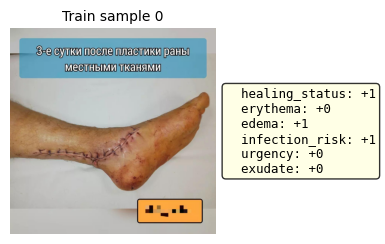

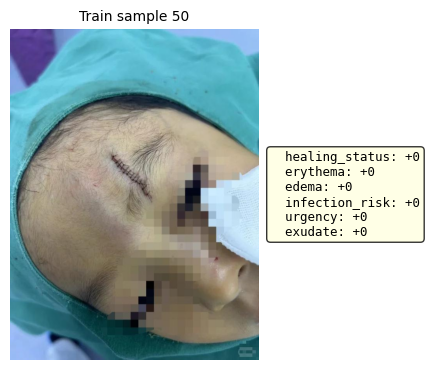

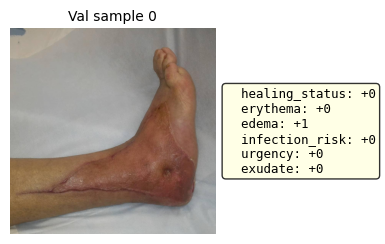

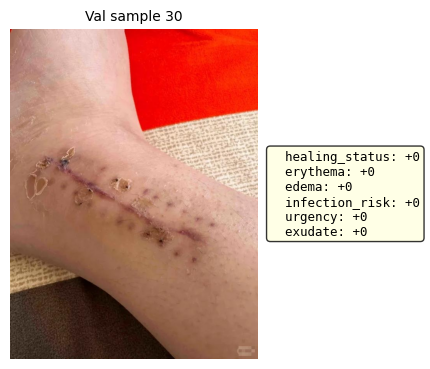

✓ Found MISSING in train[55]: ['erythema', 'edema']
  Full label vector: [1.0, -1.0, -1.0, 0.0, 0.0, 1.0]


In [8]:
import matplotlib.pyplot as plt


def show_sample(ds_raw, ds_processed, idx, title_prefix=""):
    """Display an image alongside its encoded label vector."""
    raw_img = ds_raw[idx]["image"]
    label_vec = ds_processed[idx]["label"]

    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.imshow(raw_img)
    ax.set_title(f"{title_prefix} sample {idx}", fontsize=10)
    ax.axis("off")

    label_str = "\n".join(
        f"  {LABEL_NAMES[i]}: {label_vec[i]:+.0f}"
        + (" (MISSING)" if label_vec[i] == -1.0 else "")
        for i in range(NUM_LABELS)
    )
    ax.text(
        1.05, 0.5, label_str,
        transform=ax.transAxes, fontsize=9, verticalalignment="center",
        fontfamily="monospace",
        bbox=dict(boxstyle="round", facecolor="lightyellow", alpha=0.8),
    )
    plt.tight_layout()
    plt.show()


# Show 4 samples: 2 train, 2 val
for i in [0, 50]:
    show_sample(train_ds_raw, train_ds, i, title_prefix="Train")
for i in [0, 30]:
    show_sample(val_ds_raw, val_ds, i, title_prefix="Val")

# ── Verify MISSING encoding ──────────────────────────────────────────────────
missing_found = False
for idx in range(len(train_ds)):
    label_vec = train_ds[idx]["label"]
    if -1.0 in label_vec:
        missing_indices = [i for i, v in enumerate(label_vec) if v == -1.0]
        missing_names = [LABEL_NAMES[i] for i in missing_indices]
        print(f"✓ Found MISSING in train[{idx}]: {missing_names}")
        print(f"  Full label vector: {label_vec}")
        missing_found = True
        break

if not missing_found:
    print("⚠ No MISSING values found in training data — check encoding!")

## 8. Load Model with Selective Freezing

Load `google/medsiglip-448` with a 6-label classification head.
Freeze all parameters except the last 4 encoder blocks + the new head.

This reduces trainable params from ~400M to ~50-60M, fitting comfortably in T4 16GB VRAM.

In [9]:
from transformers import AutoModelForImageClassification

# ── Load pretrained model with new classification head ────────────────────────
model = AutoModelForImageClassification.from_pretrained(
    MODEL_ID,
    problem_type="multi_label_classification",
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # Head size mismatch: pretrained != 6
)

# ── Freeze all parameters ────────────────────────────────────────────────────
for param in model.parameters():
    param.requires_grad = False

# ── Unfreeze classification head (randomly initialized — MUST be trainable) ──
for param in model.classifier.parameters():
    param.requires_grad = True

# ── Unfreeze last N encoder blocks ───────────────────────────────────────────
encoder_layers = model.vision_model.encoder.layers
total_layers = len(encoder_layers)
print(f"Encoder has {total_layers} layers. Unfreezing last {N_UNFREEZE}...")

for layer in encoder_layers[-N_UNFREEZE:]:
    for param in layer.parameters():
        param.requires_grad = True

# ── Print parameter counts ───────────────────────────────────────────────────
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"\nParameter summary:")
print(f"  Total:     {total_params:>12,}")
print(f"  Trainable: {trainable_params:>12,} ({100*trainable_params/total_params:.1f}%)")
print(f"  Frozen:    {frozen_params:>12,} ({100*frozen_params/total_params:.1f}%)")

# ── Move to device and check VRAM ────────────────────────────────────────────
model = model.to(device)

if torch.cuda.is_available():
    vram_used = torch.cuda.memory_allocated() / 1e9
    vram_total = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"\nVRAM after model load: {vram_used:.2f} / {vram_total:.1f} GB")
    if vram_used > vram_total * 0.7:
        print("⚠ VRAM usage is high — consider reducing N_UNFREEZE or BATCH_SIZE")

config.json:   0%|          | 0.00/879 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.51G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/448 [00:00<?, ?it/s]

SiglipForImageClassification LOAD REPORT from: google/medsiglip-448
Key                                                          | Status     | 
-------------------------------------------------------------+------------+-
text_model.encoder.layers.{0...26}.self_attn.k_proj.bias     | UNEXPECTED | 
text_model.encoder.layers.{0...26}.mlp.fc1.weight            | UNEXPECTED | 
text_model.encoder.layers.{0...26}.self_attn.v_proj.weight   | UNEXPECTED | 
text_model.encoder.layers.{0...26}.layer_norm1.weight        | UNEXPECTED | 
text_model.encoder.layers.{0...26}.self_attn.out_proj.bias   | UNEXPECTED | 
text_model.encoder.layers.{0...26}.self_attn.v_proj.bias     | UNEXPECTED | 
logit_bias                                                   | UNEXPECTED | 
text_model.encoder.layers.{0...26}.layer_norm1.bias          | UNEXPECTED | 
text_model.encoder.layers.{0...26}.mlp.fc2.bias              | UNEXPECTED | 
text_model.encoder.layers.{0...26}.self_attn.q_proj.bias     | UNEXPECTED | 
text_mod

Encoder has 27 layers. Unfreezing last 4...

Parameter summary:
  Total:      428,572,358
  Trainable:   60,964,934 (14.2%)
  Frozen:     367,607,424 (85.8%)

VRAM after model load: 1.72 / 15.6 GB


## 9. Masked BCE Loss Function

Three labels (erythema, edema, exudate) have MISSING values encoded as `-1.0`.
Instead of dropping entire rows (losing signal for other valid labels),
the masked loss zeros out gradient contributions for MISSING entries.

Every image contributes to every label it has data for.

In [10]:
from torch.nn import BCEWithLogitsLoss


def masked_bce_loss(
    outputs: dict,
    labels: torch.Tensor,
) -> torch.Tensor:
    """
    BCE loss with per-element masking for MISSING values and class-imbalance weighting.

    Args:
        outputs: Model output dict containing 'logits' of shape (batch, 6).
        labels:  Tensor of shape (batch, 6) with values in {0.0, 1.0, -1.0}.
                 -1.0 indicates MISSING — loss for that entry is masked out.

    Returns:
        Scalar loss tensor (mean over valid entries only).
    """
    logits = outputs.get("logits")             # (batch, 6)
    mask = (labels >= 0).float()                # 1 where valid, 0 where MISSING
    safe_labels = labels.clamp(min=0.0)         # Replace -1 with 0 for BCE math

    pos_weight = POS_WEIGHT.to(logits.device)
    loss_fct = BCEWithLogitsLoss(pos_weight=pos_weight, reduction="none")
    per_element_loss = loss_fct(logits, safe_labels)  # (batch, 6)
    masked_loss = per_element_loss * mask               # Zero out MISSING

    # Mean over valid entries only (prevents bias from batch MISSING counts)
    num_valid = mask.sum()
    if num_valid == 0:
        return torch.tensor(0.0, device=logits.device, requires_grad=True)

    return masked_loss.sum() / num_valid


# ── Unit test: verify MISSING entries are masked ─────────────────────────────
print("Running masked loss unit test...")

# Fake logits and labels with known MISSING entries
_test_logits = torch.tensor([[0.5, 0.3, -0.2, 0.1, 0.4, 0.6]])
_test_labels_valid = torch.tensor([[1.0, 0.0, 1.0, 0.0, 1.0, 0.0]])   # All valid
_test_labels_missing = torch.tensor([[1.0, 0.0, -1.0, 0.0, 1.0, -1.0]])  # Entries 2,5 MISSING

# Compute loss with all valid
_loss_valid = masked_bce_loss({"logits": _test_logits}, _test_labels_valid)

# Compute loss with MISSING
_loss_masked = masked_bce_loss({"logits": _test_logits}, _test_labels_missing)

print(f"  Loss (all valid):     {_loss_valid.item():.4f}  (6/6 entries contribute)")
print(f"  Loss (2 MISSING):     {_loss_masked.item():.4f}  (4/6 entries contribute)")
print(f"  Losses differ: {_loss_valid.item() != _loss_masked.item()} (expected: True)")

# Verify gradient flows for valid entries but not MISSING
_test_logits_grad = torch.tensor([[0.5, 0.3, -0.2, 0.1, 0.4, 0.6]], requires_grad=True)
_loss_for_grad = masked_bce_loss({"logits": _test_logits_grad}, _test_labels_missing)
_loss_for_grad.backward()
grad = _test_logits_grad.grad[0]
print(f"  Gradients: {[round(g, 4) for g in grad.tolist()]}")
print(f"  MISSING positions (2,5) have zero grad: {grad[2].item() == 0.0 and grad[5].item() == 0.0}")
print("✓ Masked loss unit test passed!")

Running masked loss unit test...
  Loss (all valid):     2.0586  (6/6 entries contribute)
  Loss (2 MISSING):     1.5196  (4/6 entries contribute)
  Losses differ: True (expected: True)
  Gradients: [-0.134, 0.1436, 0.0, 0.1312, -0.7444, 0.0]
  MISSING positions (2,5) have zero grad: True
✓ Masked loss unit test passed!


## 10. Evaluation Metrics

Macro-averaged One-vs-Rest ROC AUC + per-label sensitivity/specificity.
For labels with MISSING values in the eval set, metrics are computed only on non-MISSING samples.

In [11]:
from sklearn.metrics import roc_auc_score


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def compute_metrics(eval_pred):
    """
    Compute evaluation metrics, handling MISSING values (-1) in labels.

    Returns:
        Dict with 'roc_auc_macro' and per-label AUC.
    """
    logits, labels = eval_pred
    scores = sigmoid(logits)

    results = {}
    per_label_auc = []

    for i, name in enumerate(LABEL_NAMES):
        # Mask out MISSING entries for this label
        valid_mask = labels[:, i] >= 0
        if valid_mask.sum() == 0:
            continue

        y_true = labels[valid_mask, i]
        y_score = scores[valid_mask, i]

        # Need at least one sample of each class for AUC
        if len(np.unique(y_true)) < 2:
            results[f"auc_{name}"] = float("nan")
            continue

        try:
            auc = roc_auc_score(y_true, y_score)
            per_label_auc.append(auc)
            results[f"auc_{name}"] = auc
        except ValueError:
            results[f"auc_{name}"] = float("nan")

    # Macro-averaged AUC (only over labels with valid AUC)
    if per_label_auc:
        results["roc_auc_macro"] = np.mean(per_label_auc)
    else:
        results["roc_auc_macro"] = float("nan")

    return results


def compute_full_metrics(logits, labels, threshold=0.5):
    """
    Compute detailed metrics including sensitivity/specificity per label.
    Used for final test evaluation (not during training).
    """
    scores = sigmoid(logits)
    results = {}

    print("\n" + "=" * 70)
    print(f"{'Label':<20} {'AUC':>8} {'Sens':>8} {'Spec':>8} {'N valid':>8}")
    print("=" * 70)

    all_aucs = []
    for i, name in enumerate(LABEL_NAMES):
        valid_mask = labels[:, i] >= 0
        n_valid = valid_mask.sum()
        y_true = labels[valid_mask, i]
        y_score = scores[valid_mask, i]
        y_pred = (y_score > threshold).astype(int)

        # AUC
        try:
            auc = roc_auc_score(y_true, y_score) if len(np.unique(y_true)) >= 2 else float("nan")
        except ValueError:
            auc = float("nan")

        # Sensitivity and specificity
        tp = ((y_pred == 1) & (y_true == 1)).sum()
        tn = ((y_pred == 0) & (y_true == 0)).sum()
        fn = ((y_pred == 0) & (y_true == 1)).sum()
        fp = ((y_pred == 1) & (y_true == 0)).sum()
        sens = tp / (tp + fn) if (tp + fn) > 0 else float("nan")
        spec = tn / (tn + fp) if (tn + fp) > 0 else float("nan")

        if not np.isnan(auc):
            all_aucs.append(auc)

        results[f"auc_{name}"] = auc
        results[f"sens_{name}"] = sens
        results[f"spec_{name}"] = spec

        print(f"{name:<20} {auc:>8.4f} {sens:>8.4f} {spec:>8.4f} {n_valid:>8d}")

    macro_auc = np.mean(all_aucs) if all_aucs else float("nan")
    results["roc_auc_macro"] = macro_auc
    print("=" * 70)
    print(f"{'Macro AUC':<20} {macro_auc:>8.4f}")
    print("=" * 70)

    return results


print("✓ Metrics functions defined")

✓ Metrics functions defined


## 11. Data Collator

In [12]:
def collate_fn(examples):
    """
    Collate function for Trainer.

    Stacks pixel_values into a (batch, 3, 448, 448) tensor
    and labels into a (batch, 6) float tensor (with -1.0 for MISSING).
    """
    pixel_values = torch.stack([torch.tensor(ex["pixel_values"]) for ex in examples])
    labels = torch.tensor([ex["label"] for ex in examples], dtype=torch.float)
    return {"pixel_values": pixel_values, "labels": labels}


# ── Quick verification ────────────────────────────────────────────────────────
_test_batch = collate_fn([train_ds[0], train_ds[1]])
print(f"Collated batch shapes:")
print(f"  pixel_values: {_test_batch['pixel_values'].shape}")   # (2, 3, 448, 448)
print(f"  labels:       {_test_batch['labels'].shape}")          # (2, 6)
print(f"  labels dtype: {_test_batch['labels'].dtype}")          # float32
print(f"  labels[0]:    {_test_batch['labels'][0].tolist()}")

Collated batch shapes:
  pixel_values: torch.Size([2, 3, 448, 448])
  labels:       torch.Size([2, 6])
  labels dtype: torch.float32
  labels[0]:    [1.0, 0.0, 1.0, 1.0, 0.0, 0.0]


## 12. Trainer Setup

Uses a **subclassed Trainer** to inject the masked BCE loss.
This approach works across all `transformers` versions (safer than `compute_loss_func`
parameter which was introduced in ~4.46.0 and may be unavailable on some Kaggle kernels).

### Training Configuration Summary
| Parameter | Value | Rationale |
|---|---|---|
| Effective batch size | 64 (4×16) | Matches Google's 8×8 |
| Epochs | 5 | More passes for 480-image dataset |
| Learning rate | 5e-5 | Matches Google's reference |
| Scheduler | Cosine | Matches Google's reference |
| fp16 | True | T4 VRAM optimization |
| Model selection | eval_loss | Val set too small (69) for reliable AUC |

In [14]:
from transformers import Trainer, TrainingArguments


class WoundClassificationTrainer(Trainer):
    """
    Custom Trainer that uses masked BCE loss for MISSING label handling.

    Subclassing Trainer.compute_loss() is more portable across transformers
    versions than the compute_loss_func parameter.
    """

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        loss = masked_bce_loss(outputs, labels)
        return (loss, outputs) if return_outputs else loss


# ── Training arguments ────────────────────────────────────────────────────────
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,  # Larger batch for eval (no grad)
    gradient_accumulation_steps=GRAD_ACCUM,
    learning_rate=LR,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    lr_scheduler_type=SCHEDULER,
    fp16=FP16,
    logging_steps=1,                    # ~7.5 steps/epoch — log every step
    save_strategy="epoch",
    eval_strategy="epoch",              # renamed from evaluation_strategy in transformers >=4.46
    metric_for_best_model="eval_loss",  # Val set too small for reliable AUC
    greater_is_better=False,            # Lower loss = better
    load_best_model_at_end=True,
    report_to="tensorboard",
    push_to_hub=False,                  # Push manually after evaluation
    remove_unused_columns=False,        # Keep our custom columns
    dataloader_num_workers=2,
    save_total_limit=3,                 # Keep only 3 best checkpoints
)

# ── Create Trainer ───────────────────────────────────────────────────────────
trainer = WoundClassificationTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)

print(f"✓ Trainer initialized")
print(f"  Effective batch size: {BATCH_SIZE * GRAD_ACCUM}")
forward_passes = (len(train_ds) + BATCH_SIZE - 1) // BATCH_SIZE
optimizer_steps = (forward_passes + GRAD_ACCUM - 1) // GRAD_ACCUM
print(f"  Forward passes per epoch: {forward_passes}")
print(f"  Optimizer steps per epoch: {optimizer_steps}")
print(f"  Total optimizer steps: {EPOCHS * optimizer_steps}")
print(f"  Model selection: best eval_loss (lower is better)")

2026-02-21 09:47:14.522715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771667234.696334      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771667234.745182      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771667235.148869      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771667235.148897      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771667235.148900      55 computation_placer.cc:177] computation placer alr

✓ Trainer initialized
  Effective batch size: 64
  Forward passes per epoch: 120
  Optimizer steps per epoch: 8
  Total optimizer steps: 40
  Model selection: best eval_loss (lower is better)


## 13. Train

Expected training time: **15–25 minutes on T4** (vs Google's ~3 hours for SCIN on A100).
Much faster because: (a) 480 images vs thousands, (b) most params frozen.

In [15]:
import time

print("Starting training...\n")
start_time = time.time()

train_result = trainer.train()

elapsed = time.time() - start_time
print(f"\n{'='*60}")
print(f"Training complete in {elapsed/60:.1f} minutes")
print(f"{'='*60}")

# ── Check for NaN (fp16 safety) ──────────────────────────────────────────────
final_loss = train_result.training_loss
if np.isnan(final_loss):
    print("\n⚠ WARNING: Training loss is NaN!")
    print("  This likely means fp16 caused numerical instability.")
    print("  Try re-running with FP16 = False in the config cell.")
else:
    print(f"Final training loss: {final_loss:.4f}")
    print(f"Best model loaded from: {trainer.state.best_model_checkpoint}")

Starting training...



Epoch,Training Loss,Validation Loss,Auc Healing Status,Auc Erythema,Auc Edema,Auc Infection Risk,Auc Urgency,Auc Exudate,Roc Auc Macro
1,7.292958,1.275009,0.508377,0.346591,0.403922,0.551852,0.476648,0.574747,0.477023
2,9.291729,1.218635,0.532187,0.363636,0.450980,0.600000,0.535027,0.691919,0.528958
3,7.124218,1.184069,0.552910,0.379132,0.466667,0.665432,0.616758,0.779798,0.576783
4,9.532721,1.177291,0.565256,0.396694,0.476471,0.695062,0.646978,0.828283,0.601457
5,8.531834,1.175586,0.570547,0.398760,0.480392,0.698765,0.652473,0.832323,0.605543


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


Training complete in 12.8 minutes
Final training loss: 16.5754
Best model loaded from: medsiglip-448-surgwound-6label/checkpoint-40


## 14. Evaluate on Test Set

Run inference on the 137 test images and compute per-label metrics:
AUC, sensitivity, and specificity.

In [16]:
# ── Run prediction on test set ───────────────────────────────────────────────
print("Running inference on test set (137 images)...")
predictions = trainer.predict(test_ds)

test_logits = predictions.predictions  # (137, 6)
test_labels = predictions.label_ids     # (137, 6)

print(f"Logits shape: {test_logits.shape}")
print(f"Labels shape: {test_labels.shape}")

# ── Compute detailed metrics ─────────────────────────────────────────────────
test_metrics = compute_full_metrics(test_logits, test_labels, threshold=0.5)

# ── Summary ──────────────────────────────────────────────────────────────────
print(f"\nTest set macro-averaged ROC AUC: {test_metrics['roc_auc_macro']:.4f}")

Running inference on test set (137 images)...


Logits shape: (137, 6)
Labels shape: (137, 6)

Label                     AUC     Sens     Spec  N valid
healing_status         0.5458   0.8364   0.2561      137
erythema               0.5720   0.5250   0.5055      131
edema                  0.6469   0.6667   0.5000      115
infection_risk         0.5825   0.3500   0.6752      137
urgency                0.6431   0.7500   0.6446      137
exudate                0.6370   0.6875   0.4220      125
Macro AUC              0.6045

Test set macro-averaged ROC AUC: 0.6045


## 15. Save Model

Save the fine-tuned model and image processor locally.
Optionally push to Hugging Face Hub.

In [19]:
# ── Save locally ─────────────────────────────────────────────────────────────
trainer.save_model(OUTPUT_DIR)
image_processor.save_pretrained(OUTPUT_DIR)
print(f"✓ Model and image processor saved to {OUTPUT_DIR}/")

# ── Optionally push to Hugging Face Hub ──────────────────────────────────────
# Uncomment the following lines to push to your HF account:
#
HUB_MODEL_ID = "tyb343/medsiglip-448-mamaguard-wound"
trainer.push_to_hub(HUB_MODEL_ID)
image_processor.push_to_hub(HUB_MODEL_ID)
print(f"✓ Pushed to https://huggingface.co/{HUB_MODEL_ID}")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Model and image processor saved to medsiglip-448-surgwound-6label/


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

✓ Pushed to https://huggingface.co/tyb343/medsiglip-448-mamaguard-wound


## 16. Inference Demo

Load the saved model and run inference on 3 test images
to show what the downstream Gemini orchestrator would receive.

Loading weights:   0%|          | 0/450 [00:00<?, ?it/s]


────────────────────────────────────────────────────────────
Image: images/100.jpg (img_id=100)
────────────────────────────────────────────────────────────

Wound Assessment Results:
  healing_status       █████████░░░░░░░░░░░ 0.49  →  progressing
  erythema             █████████░░░░░░░░░░░ 0.50  →  absent
  edema                ███████████░░░░░░░░░ 0.59  →  present (swelling)
  infection_risk       ██████████░░░░░░░░░░ 0.51  →  elevated
  urgency              █████████░░░░░░░░░░░ 0.47  →  home care OK
  exudate              ██████████░░░░░░░░░░ 0.54  →  present (drainage)


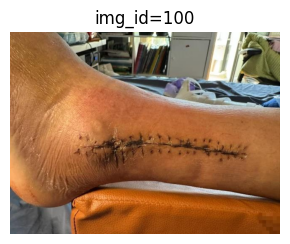


────────────────────────────────────────────────────────────
Image: images/436.jpg (img_id=436)
────────────────────────────────────────────────────────────

Wound Assessment Results:
  healing_status       ██████████░░░░░░░░░░ 0.54  →  not progressing
  erythema             ██████████░░░░░░░░░░ 0.52  →  present (redness)
  edema                █████████░░░░░░░░░░░ 0.47  →  absent
  infection_risk       █████████░░░░░░░░░░░ 0.48  →  low
  urgency              █████████░░░░░░░░░░░ 0.45  →  home care OK
  exudate              █████████░░░░░░░░░░░ 0.46  →  absent


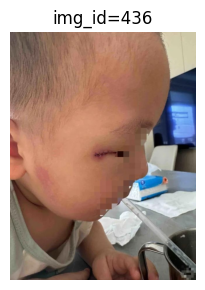


────────────────────────────────────────────────────────────
Image: images/709.jpg (img_id=709)
────────────────────────────────────────────────────────────

Wound Assessment Results:
  healing_status       ███████████░░░░░░░░░ 0.59  →  not progressing
  erythema             █████████░░░░░░░░░░░ 0.49  →  absent
  edema                █████████░░░░░░░░░░░ 0.48  →  absent
  infection_risk       ██████████░░░░░░░░░░ 0.50  →  elevated
  urgency              █████████░░░░░░░░░░░ 0.48  →  home care OK
  exudate              ███████████░░░░░░░░░ 0.57  →  present (drainage)


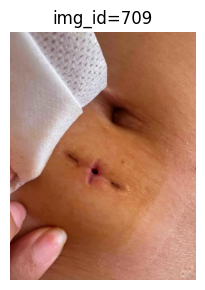


✓ Inference demo complete
  These structured scores feed into the Gemini/MedGemma orchestrator
  to generate empathetic, contextual responses for MamaGuard users.


In [20]:
# ── Load the fine-tuned model ────────────────────────────────────────────────
ft_model = AutoModelForImageClassification.from_pretrained(
    OUTPUT_DIR,
    problem_type="multi_label_classification",
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id,
    device_map="auto",
)
ft_model.eval()

# ── Human-readable label mapping ─────────────────────────────────────────────
LABEL_DISPLAY = {
    "healing_status": ("progressing", "not progressing"),
    "erythema":       ("absent", "present (redness)"),
    "edema":          ("absent", "present (swelling)"),
    "infection_risk": ("low", "elevated"),
    "urgency":        ("home care OK", "needs professional attention"),
    "exudate":        ("absent", "present (drainage)"),
}


def predict_wound(image, model, threshold=0.5):
    """
    Run wound assessment on a single image.

    Returns a dict with label names → {score: float, prediction: str}.
    """
    # Apply same preprocessing as eval (pure PIL pipeline, no augmentation)
    pixel_values = _process_image(image, augment=False)
    pixel_values = pixel_values.unsqueeze(0)  # Add batch dimension

    # Move to model's device
    model_device = next(model.parameters()).device
    pixel_values = pixel_values.to(model_device)

    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)

    probs = torch.sigmoid(outputs.logits[0]).cpu().numpy()

    results = {}
    for i, name in enumerate(LABEL_NAMES):
        neg_label, pos_label = LABEL_DISPLAY[name]
        is_positive = probs[i] > threshold
        results[name] = {
            "score": float(probs[i]),
            "prediction": pos_label if is_positive else neg_label,
        }

    return results


# ── Demo on 3 test images ────────────────────────────────────────────────────
test_df = df[df["split"] == "test"]
demo_indices = [0, 50, 100]

for idx in demo_indices:
    if idx >= len(test_df):
        continue

    row = test_df.iloc[idx]
    img_path = os.path.join(BASE_PATH, row["image_path"])
    img = PILImage.open(img_path).convert("RGB")

    results = predict_wound(img, ft_model)

    print(f"\n{chr(9472)*60}")
    print(f"Image: {row['image_path']} (img_id={row['img_id']})")
    print(f"{chr(9472)*60}")
    print("\nWound Assessment Results:")
    for name, info in results.items():
        confidence = info['score']
        prediction = info['prediction']
        bar = chr(9608) * int(confidence * 20) + chr(9617) * (20 - int(confidence * 20))
        print(f"  {name:<20s} {bar} {confidence:.2f}  →  {prediction}")

    # Show the image
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.imshow(img)
    ax.set_title(f"img_id={row['img_id']}")
    ax.axis("off")
    plt.tight_layout()
    plt.show()

print("\n✓ Inference demo complete")
print("  These structured scores feed into the Gemini/MedGemma orchestrator")
print("  to generate empathetic, contextual responses for MamaGuard users.")

## Appendix: Dynamic pos_weight Verification

Recompute `pos_weight` from the actual training data to verify the hardcoded constants.
Run this cell to double-check if you've modified the dataset or label encoding.

In [21]:
# ── Dynamically compute pos_weight from training labels ──────────────────────
train_labels = torch.tensor(train_ds["label"])  # (480, 6)

print(f"Training label tensor shape: {train_labels.shape}")
print(f"\n{'Label':<20s} {'Neg':>6} {'Pos':>6} {'Miss':>6} {'pos_weight':>10} {'Hardcoded':>10} {'Match':>6}")
print("-" * 70)

computed_pw = []
for i, name in enumerate(LABEL_NAMES):
    col = train_labels[:, i]
    n_missing = (col == -1).sum().item()
    n_pos = (col == 1).sum().item()
    n_neg = (col == 0).sum().item()
    pw = n_neg / n_pos if n_pos > 0 else float("inf")
    computed_pw.append(pw)
    hardcoded = POS_WEIGHT[i].item()
    match = abs(pw - hardcoded) < 0.05
    print(f"{name:<20s} {n_neg:>6d} {n_pos:>6d} {n_missing:>6d} {pw:>10.2f} {hardcoded:>10.2f} {'✓' if match else '✗':>6}")

print(f"\nHardcoded POS_WEIGHT: {POS_WEIGHT.tolist()}")
print(f"Computed POS_WEIGHT:  {[round(x, 2) for x in computed_pw]}")

Training label tensor shape: torch.Size([480, 6])

Label                   Neg    Pos   Miss pos_weight  Hardcoded  Match
----------------------------------------------------------------------
healing_status          282    198      0       1.42       1.42      ✓
erythema                334    129     17       2.59       2.59      ✓
edema                   328     50    102       6.56       6.56      ✓
infection_risk          402     78      0       5.15       5.15      ✓
urgency                 423     57      0       7.42       7.42      ✓
exudate                 367     70     43       5.24       5.24      ✓

Hardcoded POS_WEIGHT: [1.4199999570846558, 2.5899999141693115, 6.559999942779541, 5.150000095367432, 7.420000076293945, 5.239999771118164]
Computed POS_WEIGHT:  [1.42, 2.59, 6.56, 5.15, 7.42, 5.24]
